# 毕业论文`GRAD`
## `MCIP`气象场分析

---
*@author: Evan*\
*@date: 2023-11-04*

In [1]:
import numpy as np
import pandas as pd
import os

import sys
sys.path.append('../../../src/')
from namelist import *
from mask import polygon_to_mask, average_data
from spatial import plot_map_withobs, plot_diff_withobs

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [2]:
simvar = 'PM25'
obsvar = 'PM2.5'
month = "Sep"

low_years = np.array([2016,2015,2014])
high_years = np.array([2022,2021,2019])

low_files  = [os.path.join(processed_dir, f"{month}_{year}/{month}_{year}_chem.nc") for year in low_years]
high_files = [os.path.join(processed_dir, f"{month}_{year}/{month}_{year}_chem.nc") for year in high_years]
low_wind  = [os.path.join(processed_dir, f"{month}_{year}/{month}_{year}_mcip.nc") for year in low_years]
high_wind = [os.path.join(processed_dir, f"{month}_{year}/{month}_{year}_mcip.nc") for year in high_years]

avg_low     = average_data(low_files, simvar)
avg_high    = average_data(high_files, simvar)
avg_low_uw  = average_data(low_wind, 'uwind')
avg_high_uw = average_data(high_wind, 'uwind')
avg_low_vw  = average_data(low_wind, 'vwind')
avg_high_vw = average_data(high_wind, 'vwind')

In [3]:
sitelocation = pd.read_excel(obs_dir + 'sitelocation.xlsx')
sitelocation = sitelocation.iloc[:55,:]
sitenum = sitelocation['监测点编码'].values
sitelon = sitelocation['经度'].values
sitelat = sitelocation['纬度'].values

dfs = []
for year in low_years: 
    df = pd.read_excel(eval(f'obs{month}') + f'site_{obsvar}_{year}.xlsx',index_col=0)
    df = df[sitenum].reset_index()
    df.drop(columns='index',inplace=True)
    dfs.append(df)
    
merged_df = pd.concat(dfs)
obs_low   = merged_df.groupby(level=0).mean()

dfs = []
for year in high_years: 
    df = pd.read_excel(eval(f'obs{month}') + f'site_{obsvar}_{year}.xlsx',index_col=0)
    df = df[sitenum].reset_index()
    df.drop(columns='index',inplace=True)
    dfs.append(df)
    
merged_df = pd.concat(dfs)
obs_high  = merged_df.groupby(level=0).mean()

In [4]:
# Simulation

hours = avg_low['time'].dt.hour
daytime_indices = (hours >= 8) & (hours <= 17)
nighttime_indices = (hours < 8) | (hours >= 18)

day_low    = avg_low.sel(time = daytime_indices).mean(dim='time')
day_high   = avg_high.sel(time = daytime_indices).mean(dim='time')
night_low  = avg_low.sel(time = nighttime_indices).mean(dim='time')
night_high = avg_high.sel(time = nighttime_indices).mean(dim='time')

uw_day_low    = avg_low_uw.sel(time = daytime_indices).mean(dim='time')
uw_day_high   = avg_high_uw.sel(time = daytime_indices).mean(dim='time')
uw_night_low  = avg_low_uw.sel(time = nighttime_indices).mean(dim='time')
uw_night_high = avg_high_uw.sel(time = nighttime_indices).mean(dim='time')

vw_day_low    = avg_low_vw.sel(time = daytime_indices).mean(dim='time')
vw_day_high   = avg_high_vw.sel(time = daytime_indices).mean(dim='time')
vw_night_low  = avg_low_vw.sel(time = nighttime_indices).mean(dim='time')
vw_night_high = avg_high_vw.sel(time = nighttime_indices).mean(dim='time')

# Observation

obs_low.index = pd.date_range('2023-09-01T00','2023-09-30T23',freq='H')
obs_high.index = pd.date_range('2023-09-01T00','2023-09-30T23',freq='H')

hours = obs_low.index.hour
daytime_indices = (hours >= 8) & (hours <= 17)
nighttime_indices = (hours < 8) | (hours >= 18)

obs_day_low    = obs_low.loc[daytime_indices].mean(axis=0)
obs_night_low  = obs_low.loc[nighttime_indices].mean(axis=0)
obs_day_high   = obs_high.loc[daytime_indices].mean(axis=0)
obs_night_high = obs_high.loc[nighttime_indices].mean(axis=0)

PM25_day_low


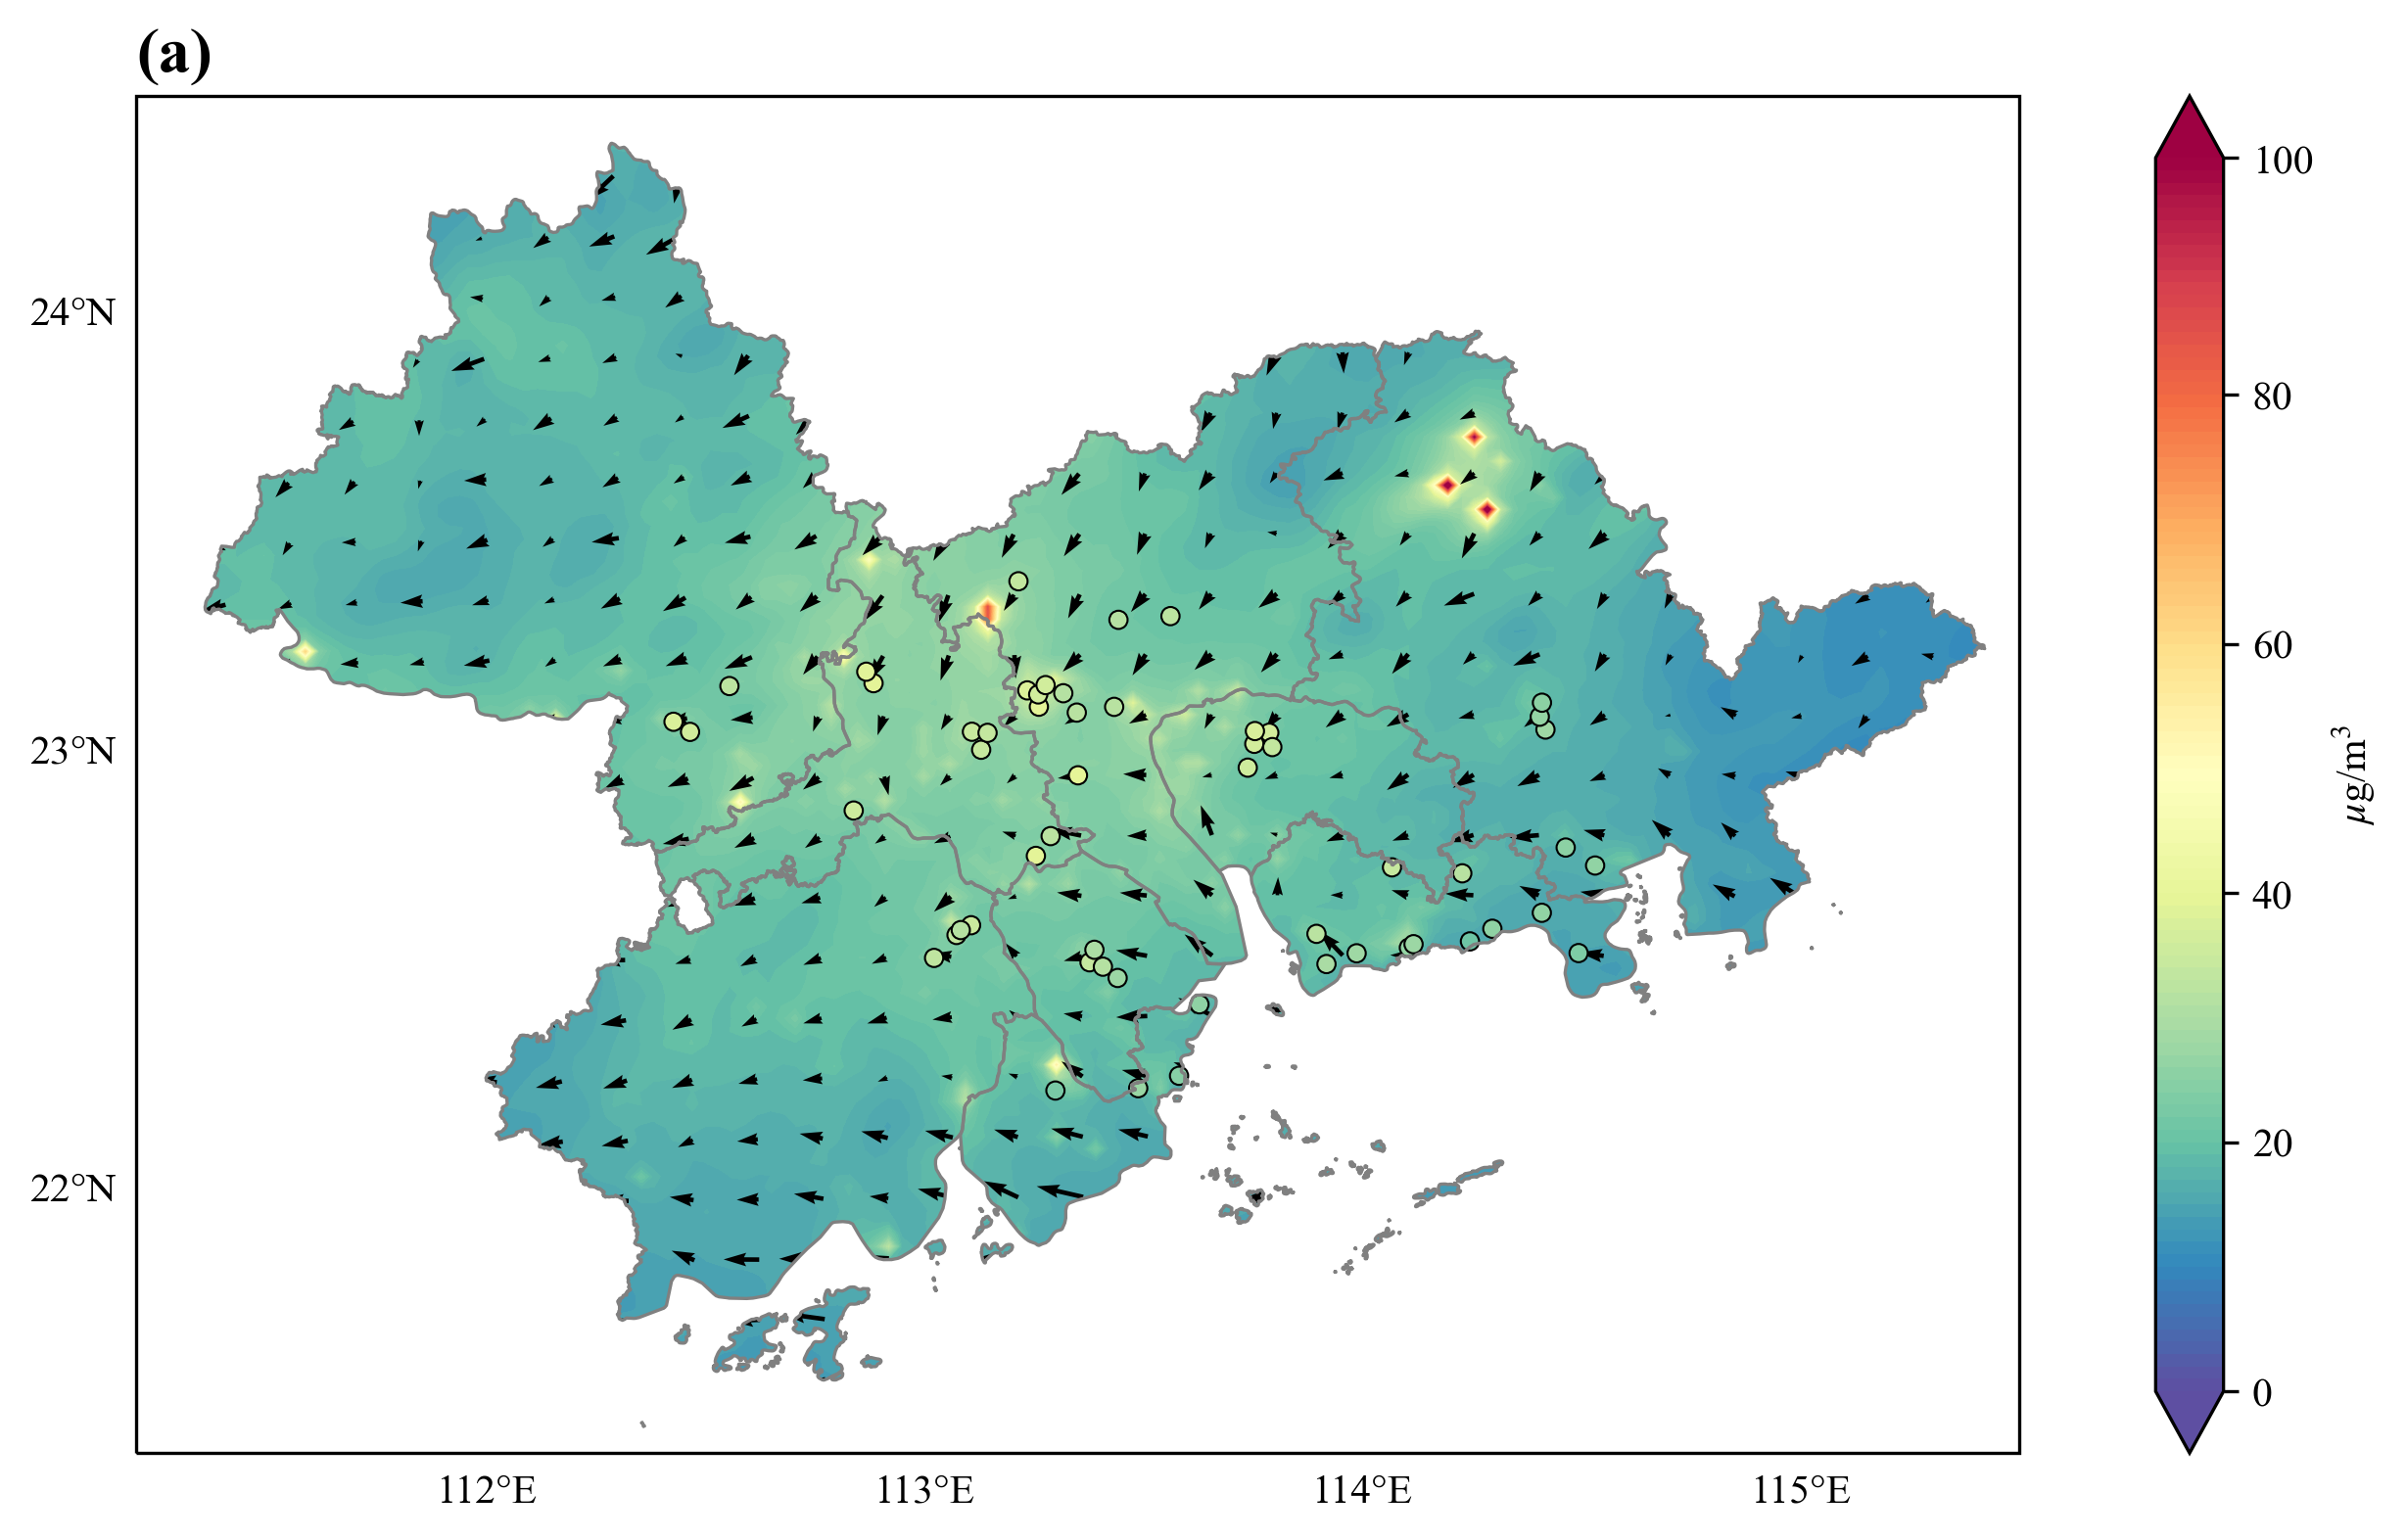

PM25_night_low


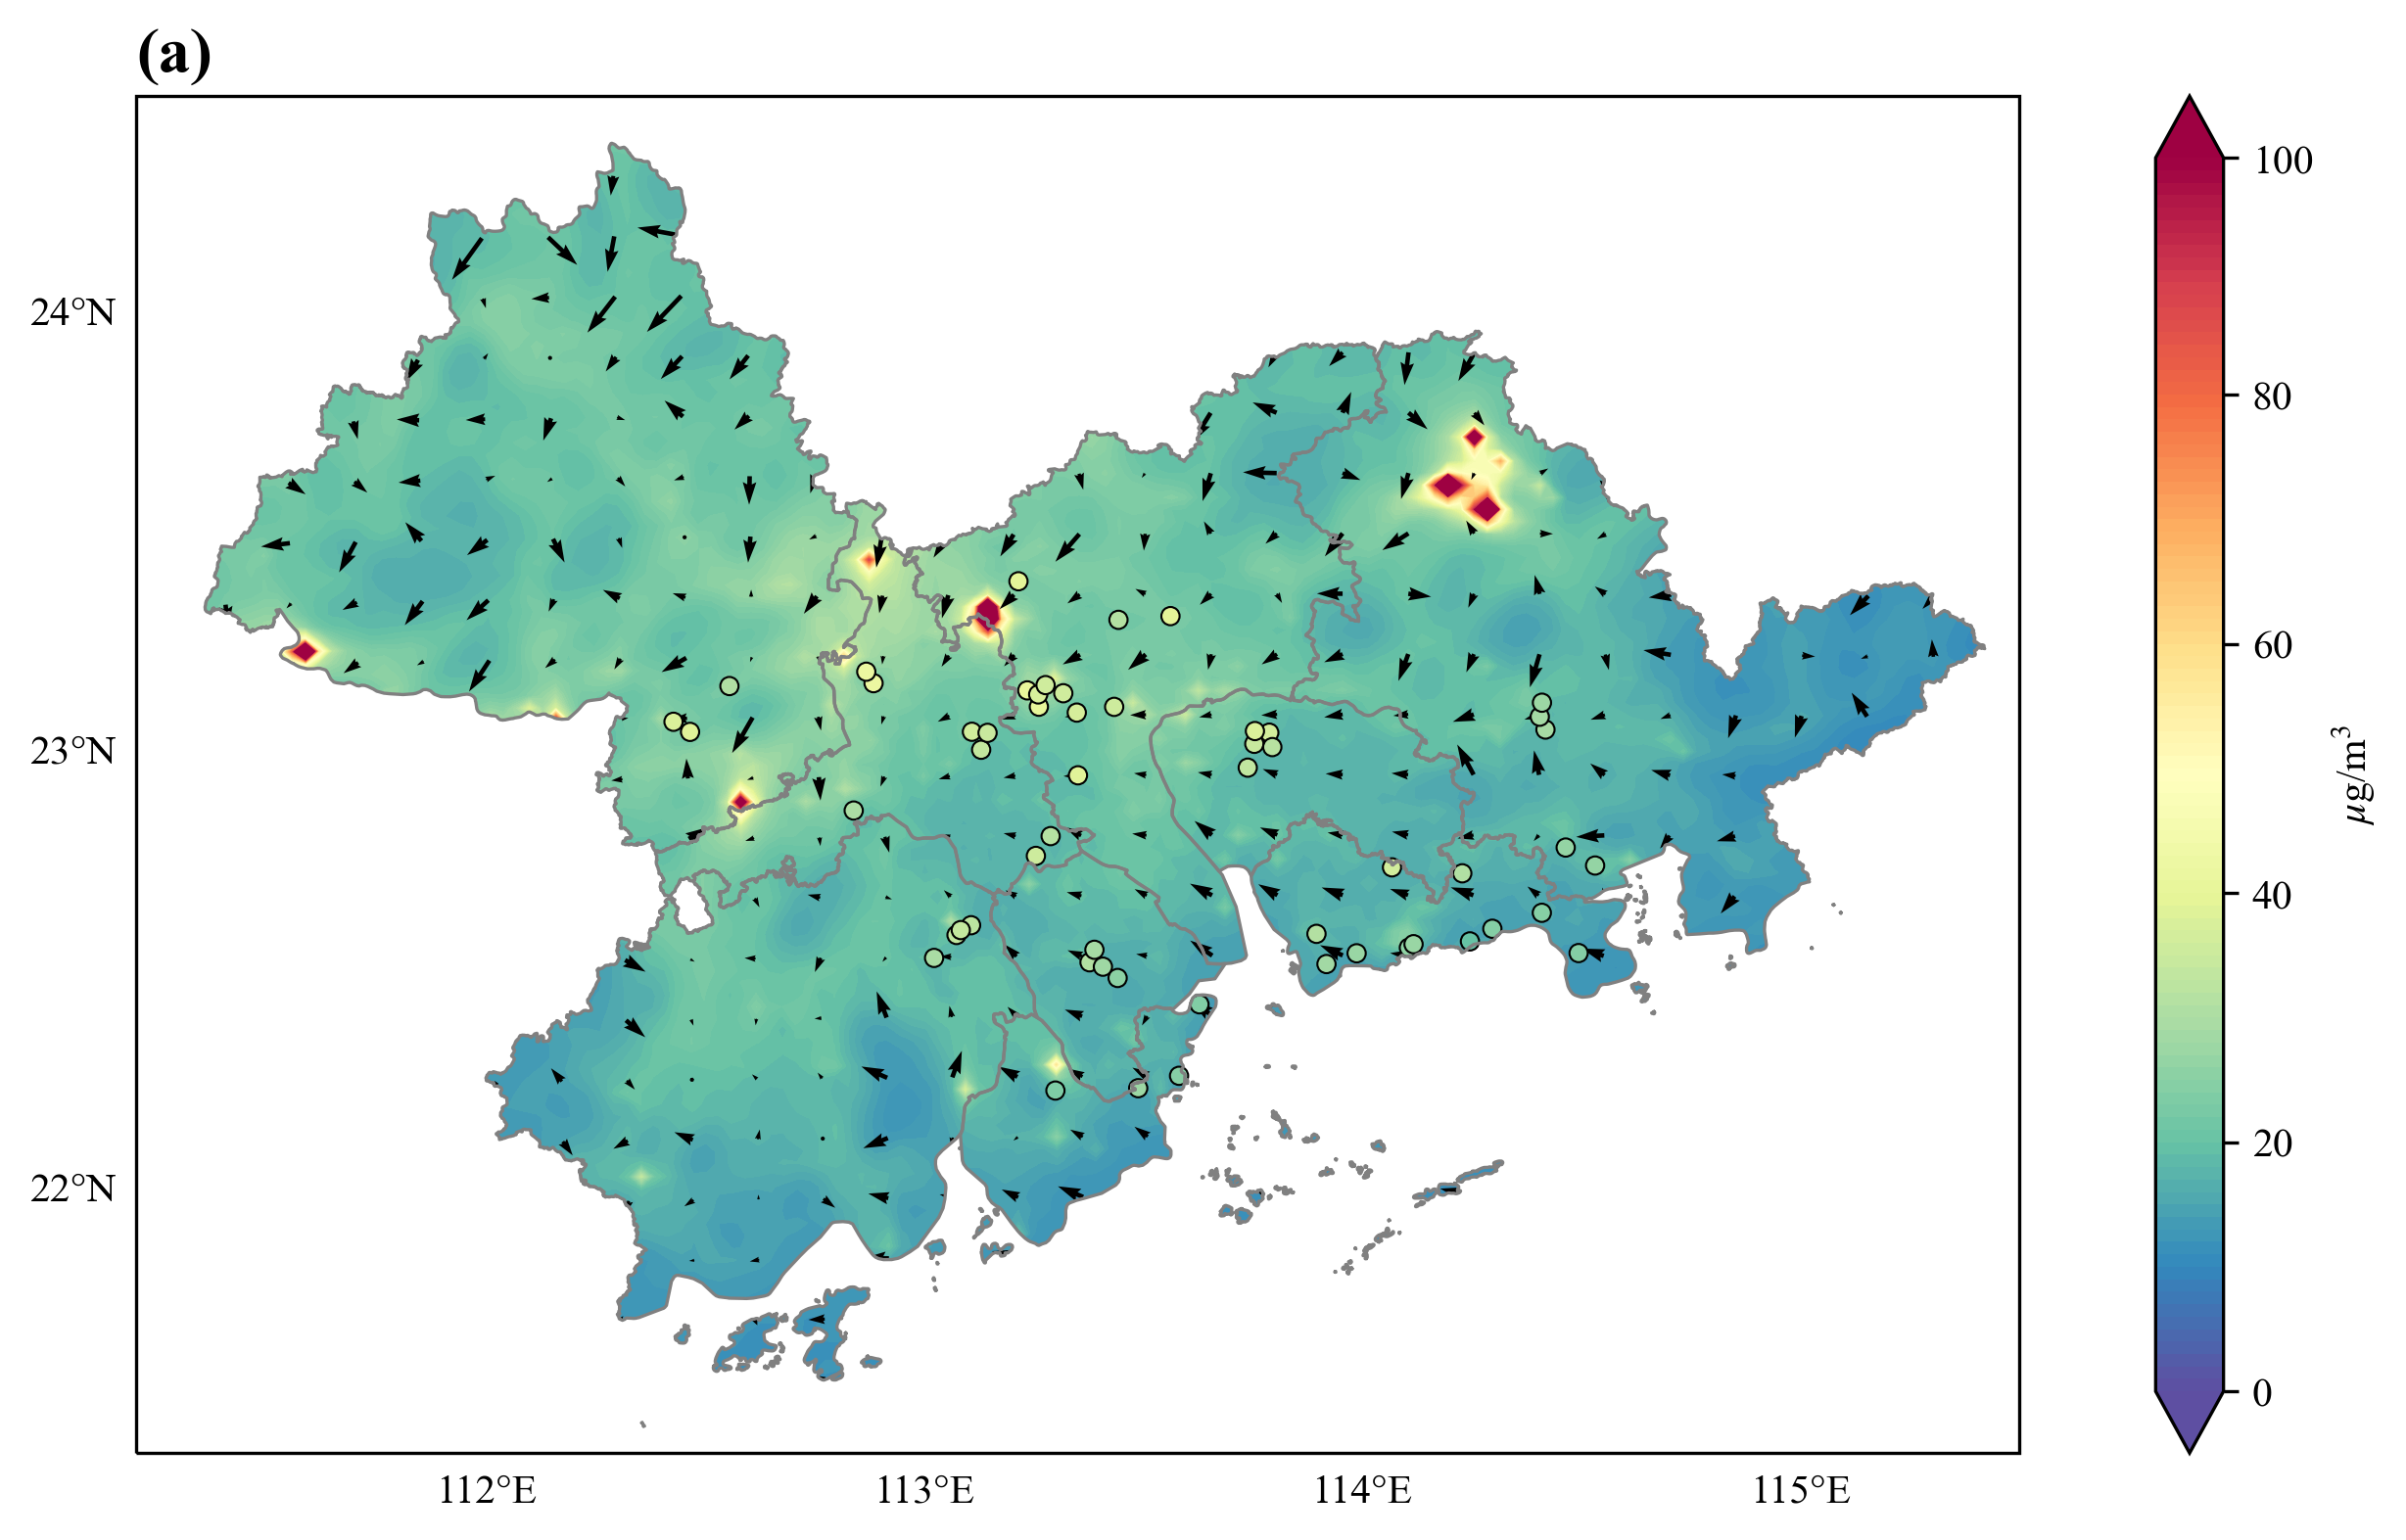

PM25_day_high


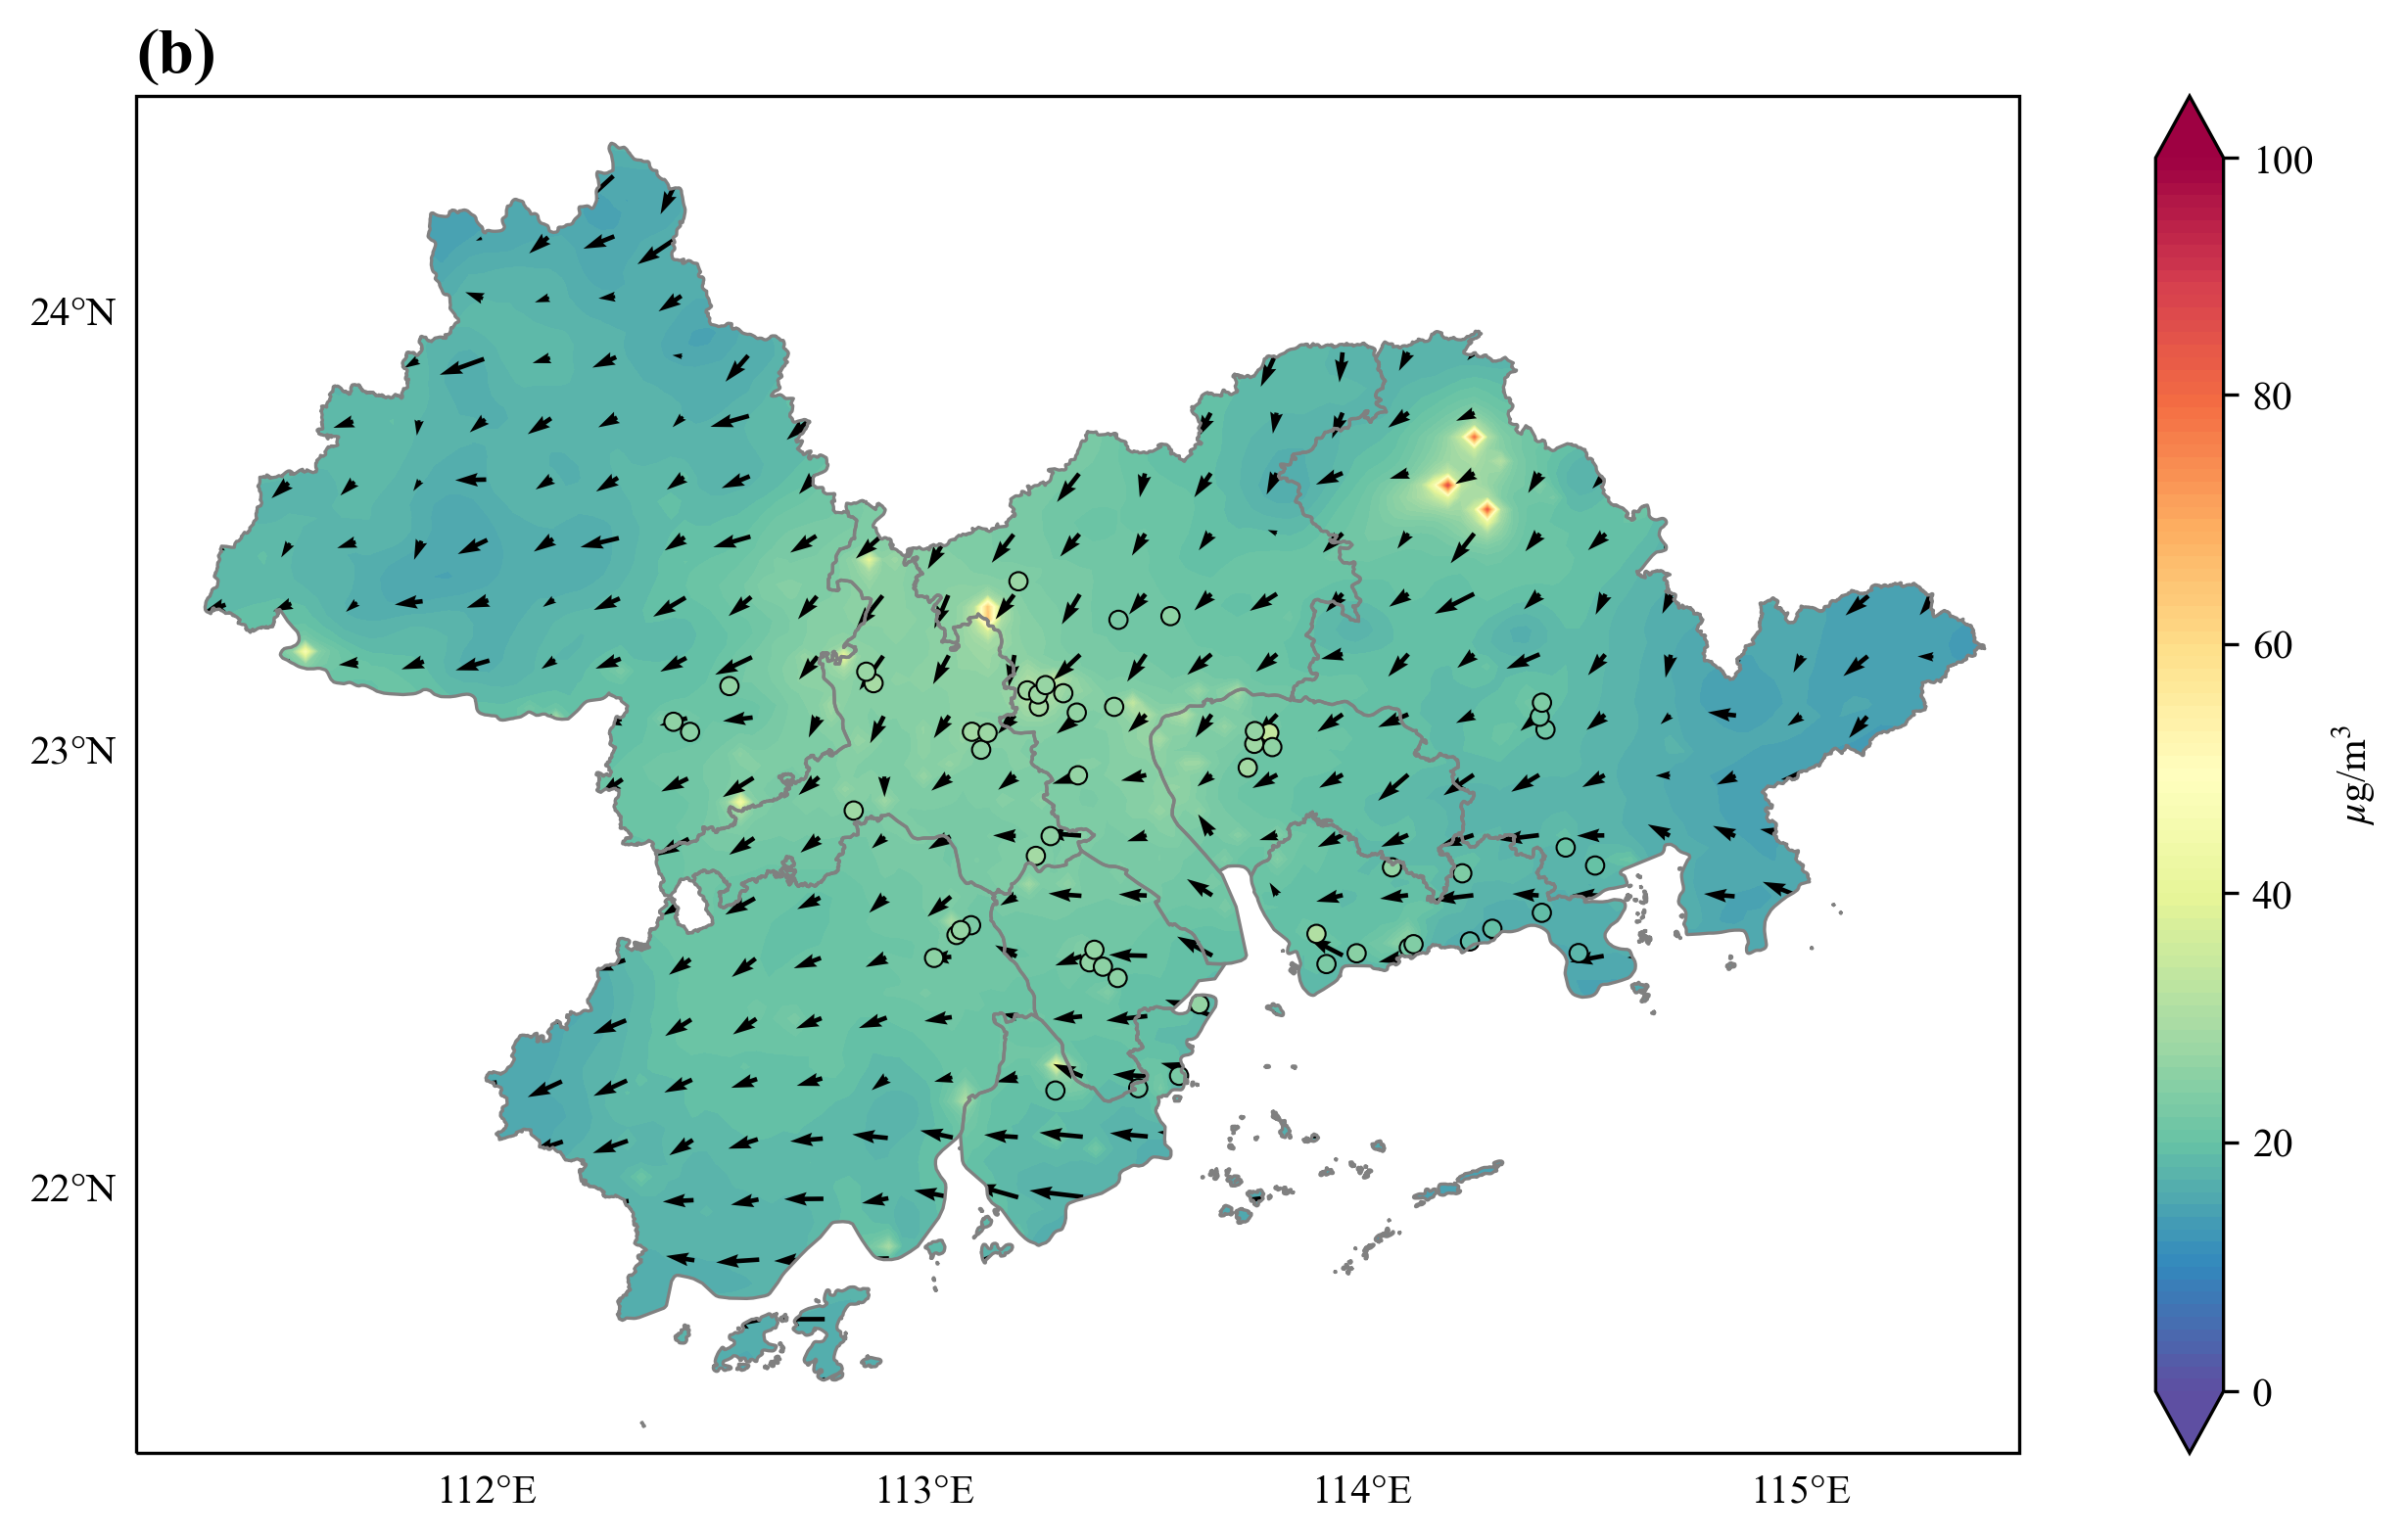

PM25_night_high


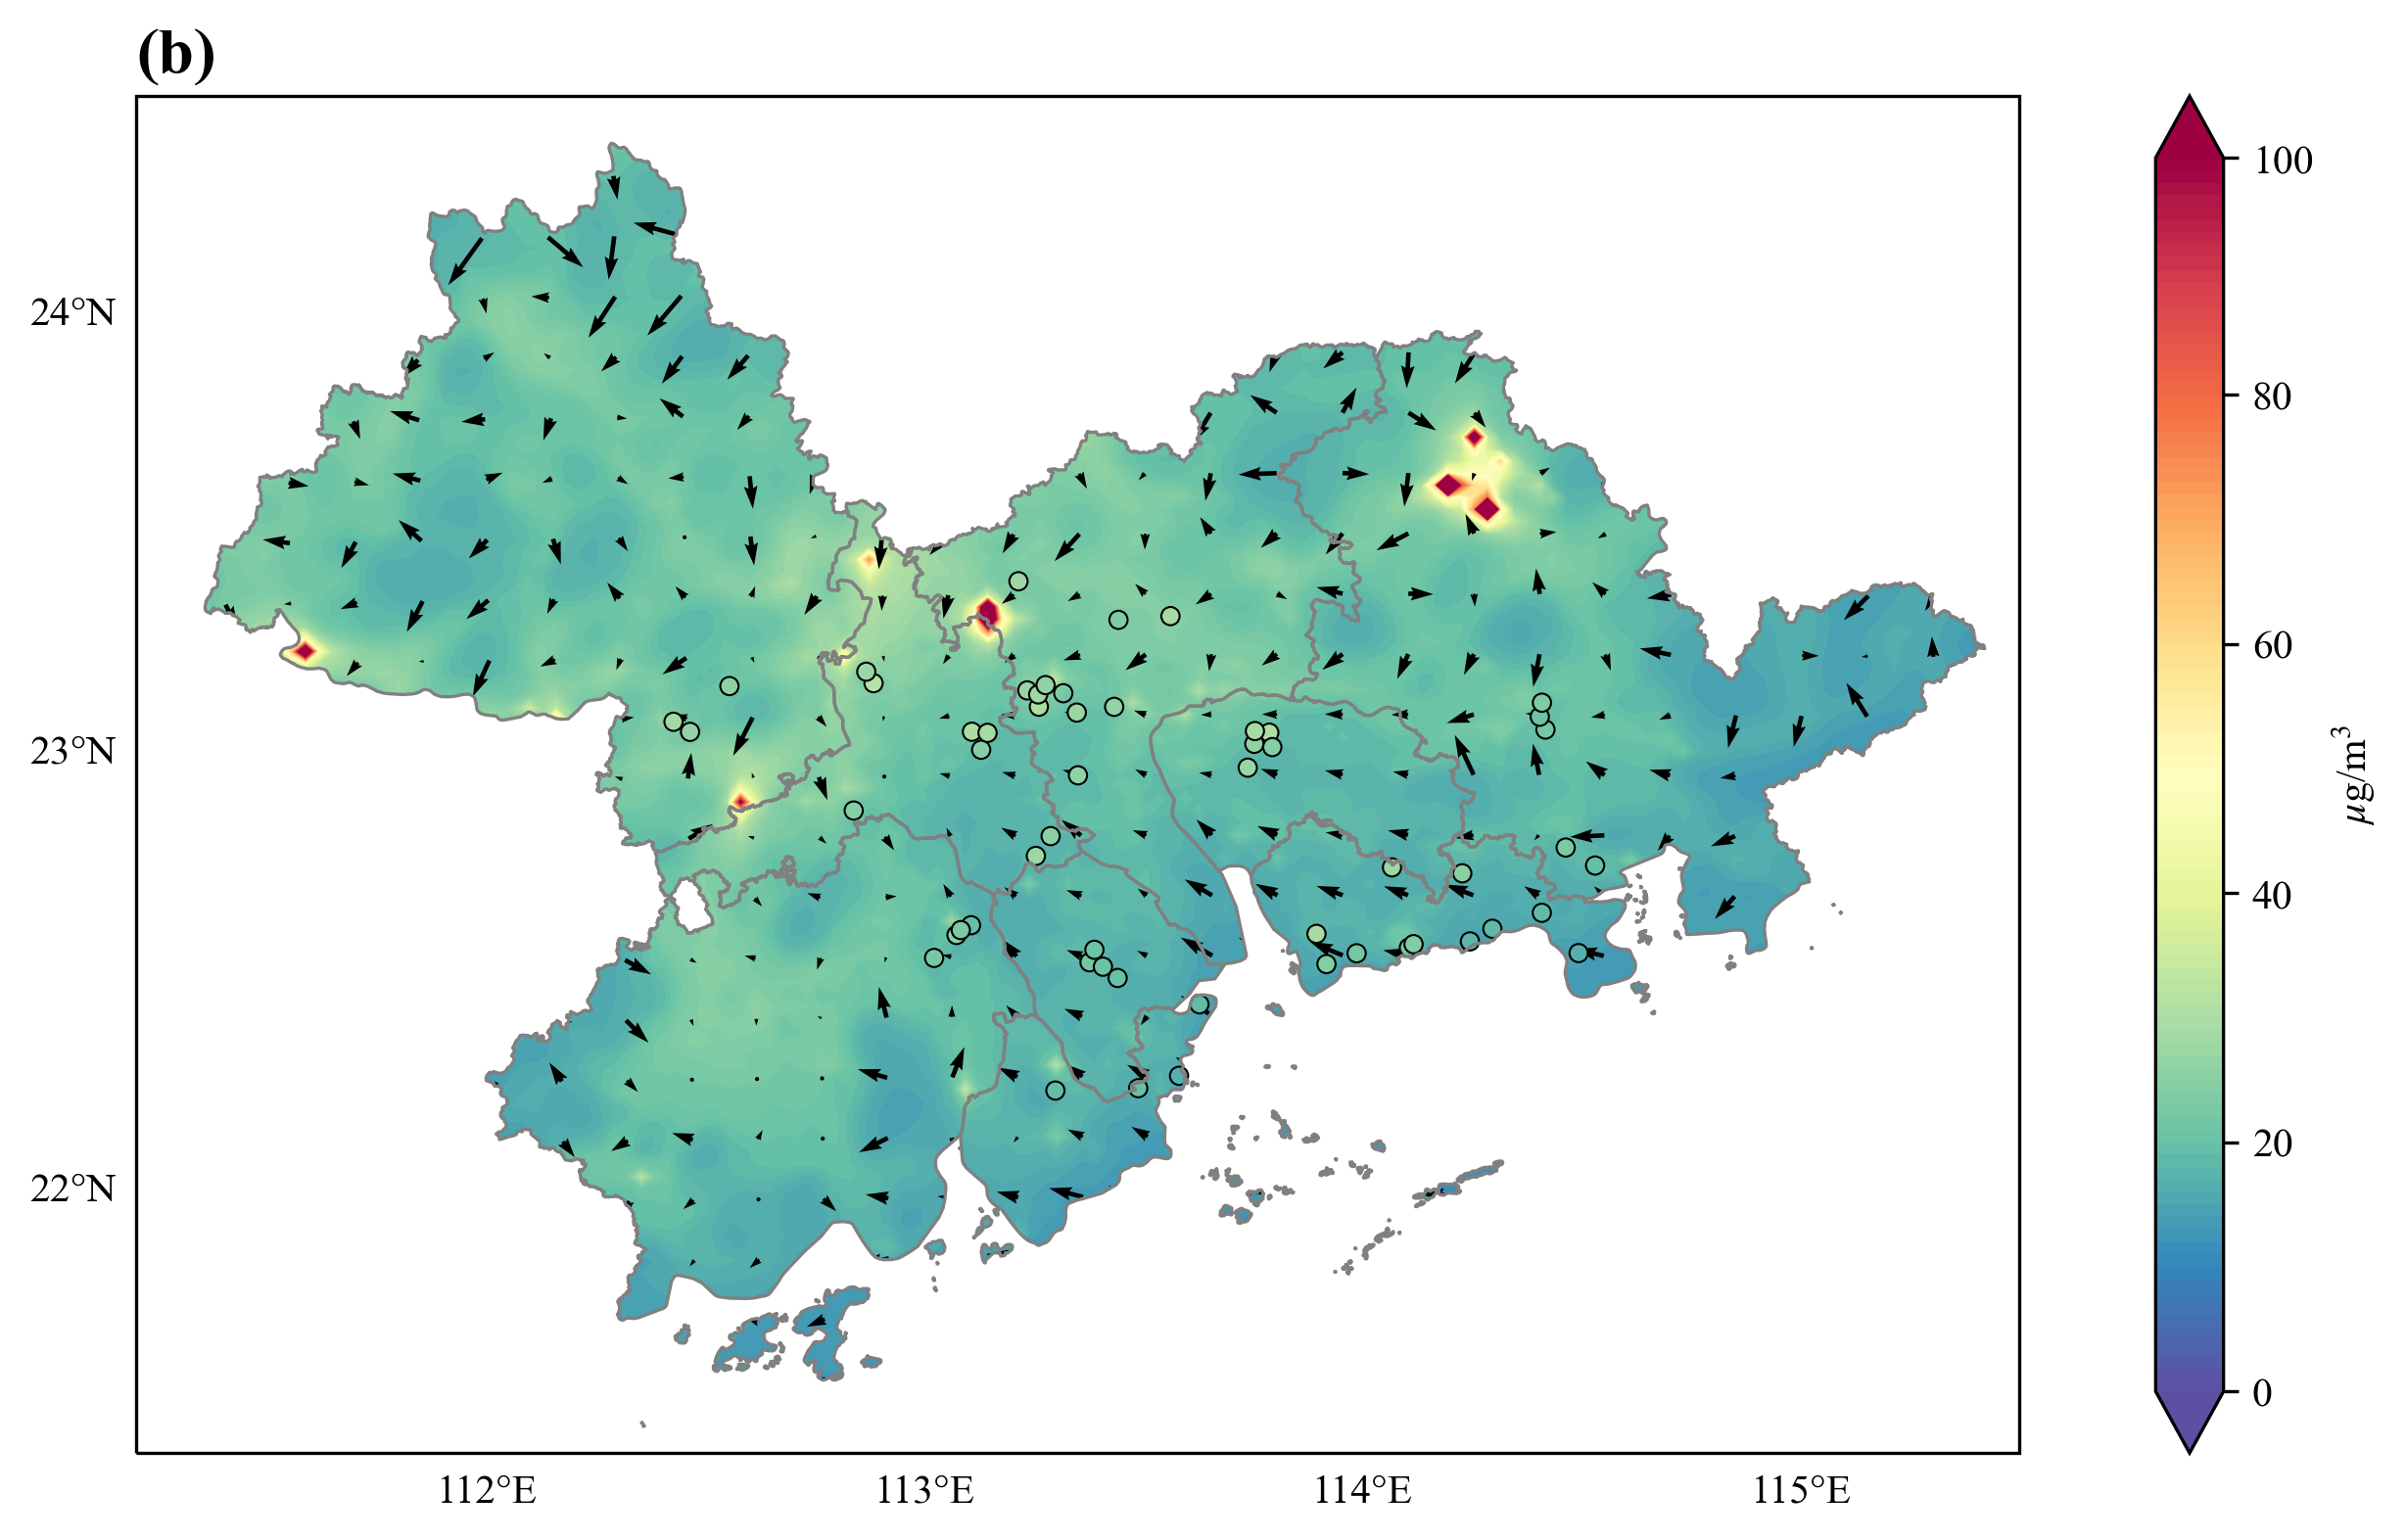

PM25_day_diff


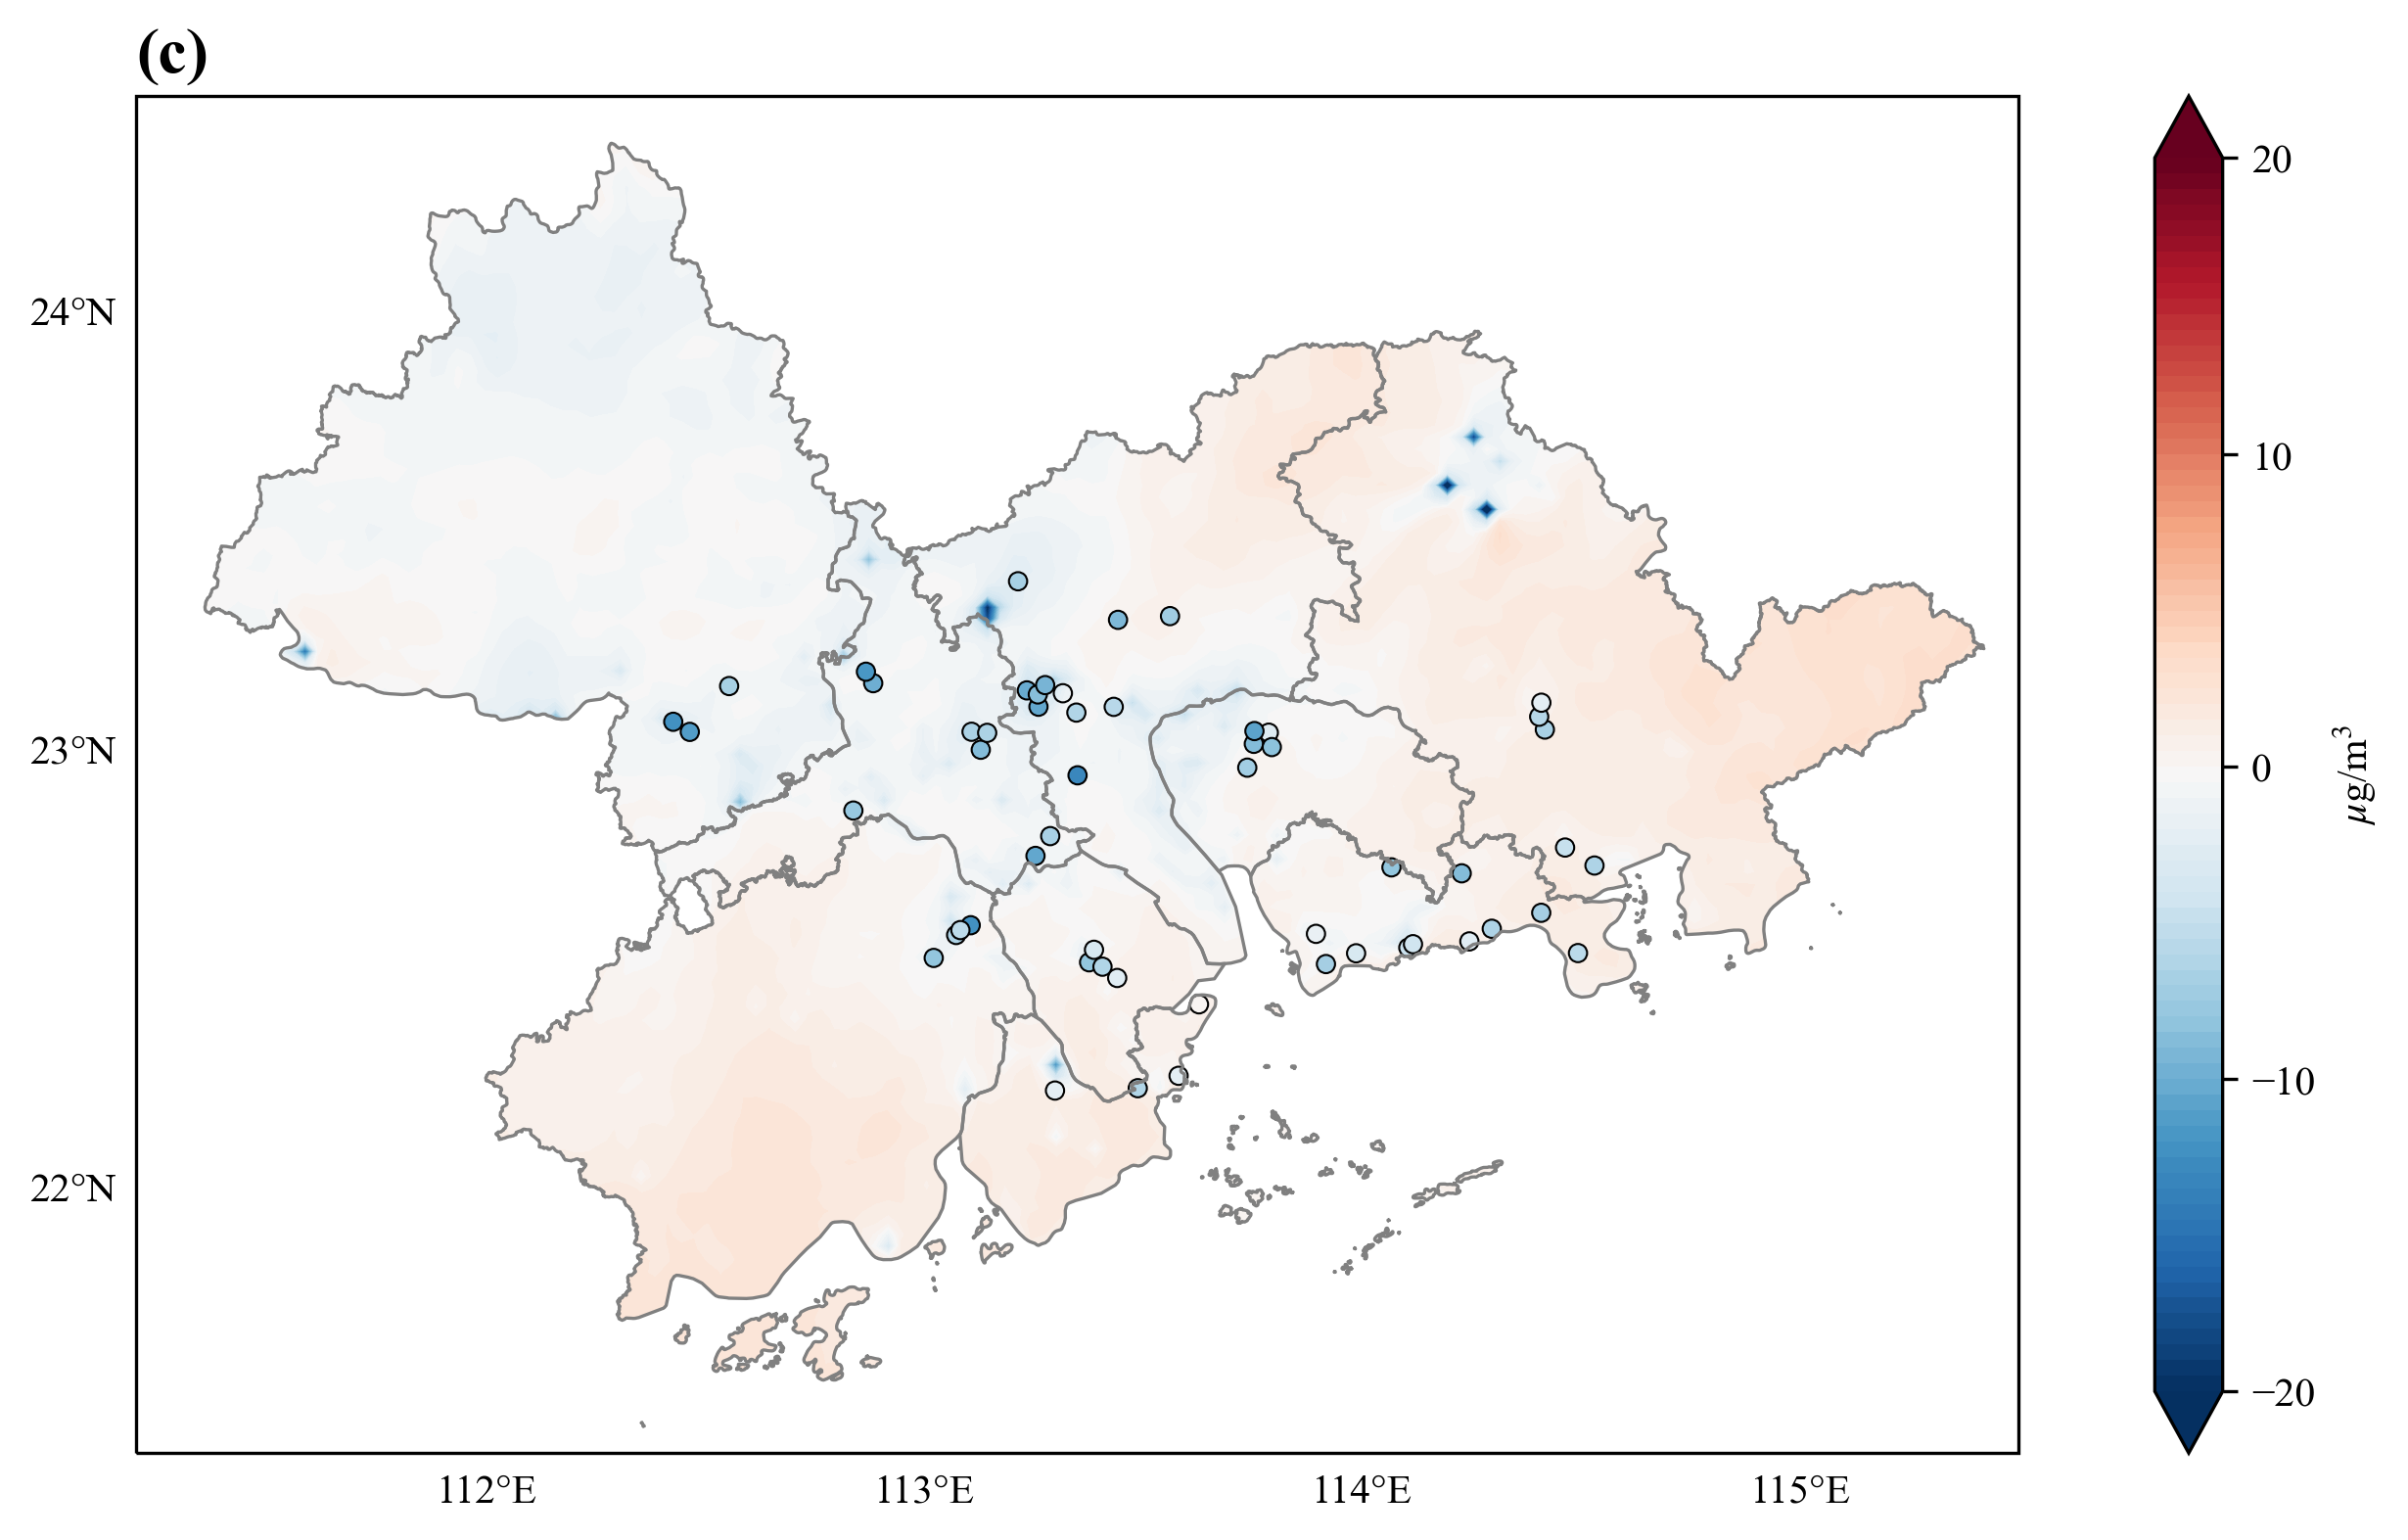

PM25_night_diff


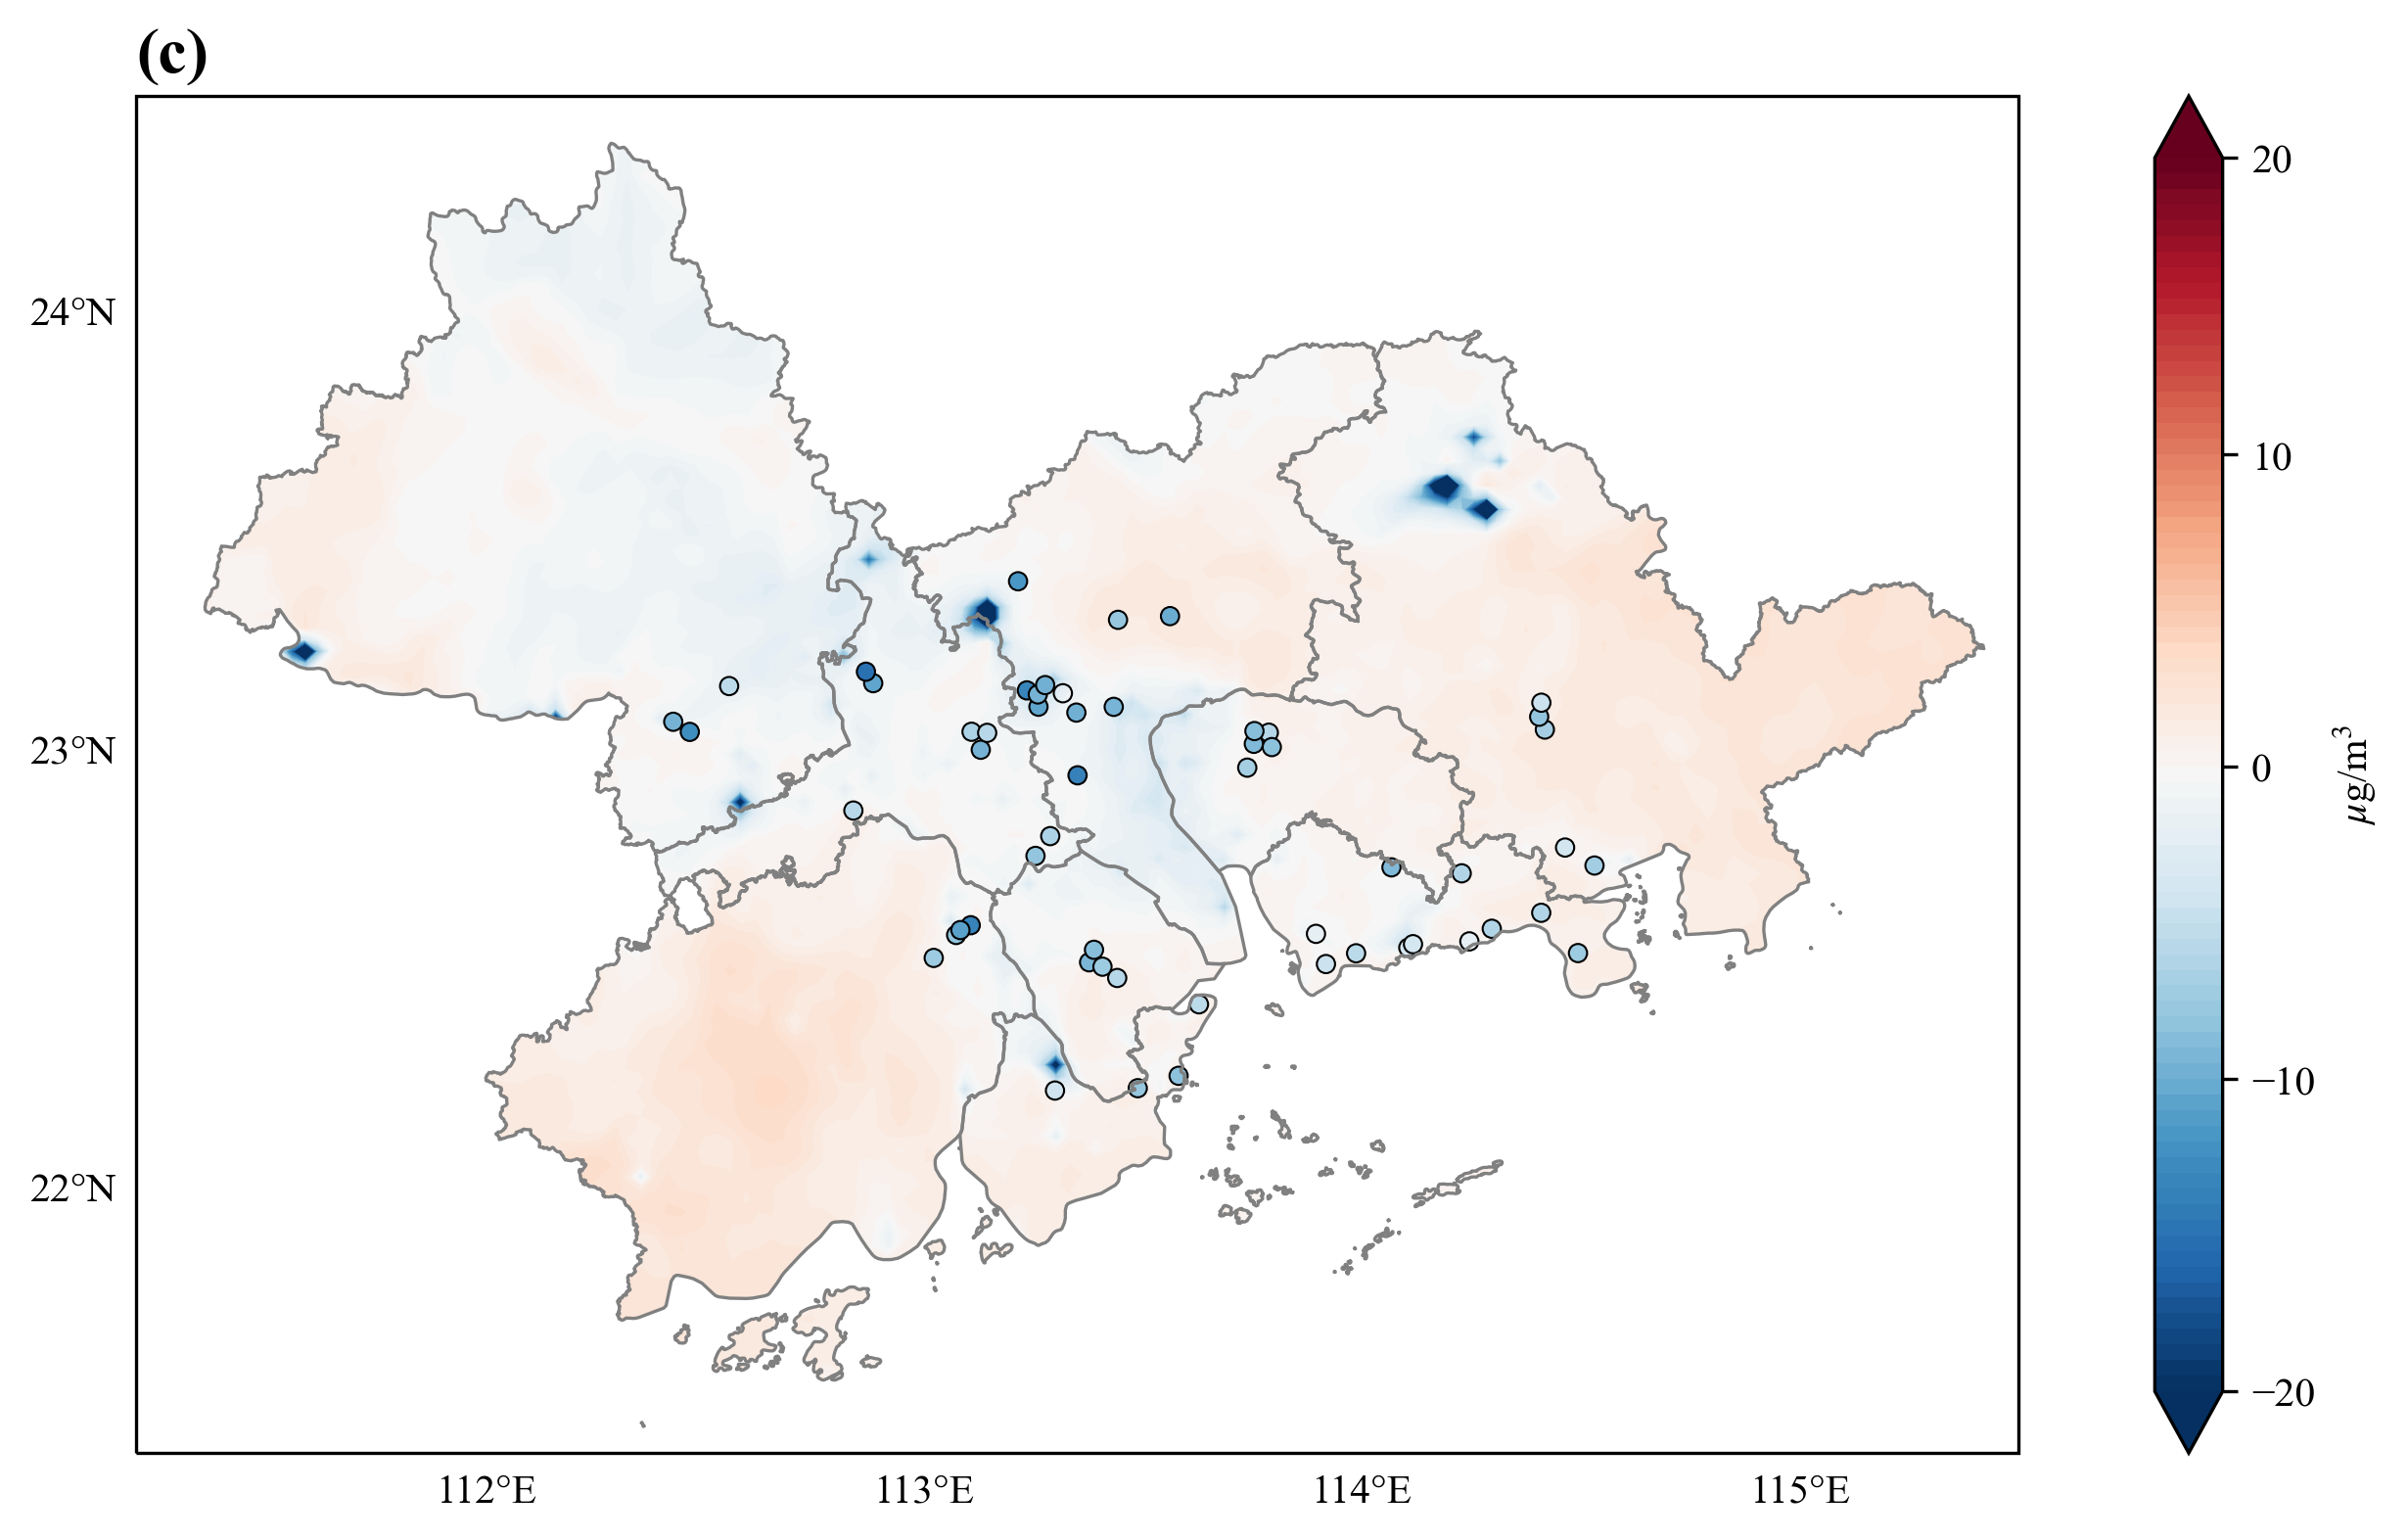

In [6]:
groups = ['low','high','diff']
periods = ['day','night']
outpath = progdir + 'Annually/figures/化学场平均态/Ground/Spatial_dn_obs/'

for group in groups:
    for period in periods:
        print(f'{simvar}_{period}_{group}')
        if group is not 'diff':
            
            cmin   = 0 if period == 'day' else 0
            cmax   = 100 if period == 'day' else 100
            cmstep = 1 if period == 'day' else 1
            cbstep = 20 if period   == 'day' else 20
            title  = '(a)' if group == 'low' else '(b)'
            
            data_to_plot = eval(f'{period}_{group}')
            uwind_to_plot = eval(f'uw_{period}_{group}')
            vwind_to_plot = eval(f'vw_{period}_{group}')
            obs_to_plot = eval(f'obs_{period}_{group}')
            
            plot_map_withobs(avg_low, cmin, cmax, cmstep, cbstep,
                        data_to_plot, uwind_to_plot, vwind_to_plot,
                        obs_to_plot,sitelon,sitelat,
                        ngrid=5, scale=100, headwidth=3,
                        title=title, colorbar_label='$\mu$g/m$^3$',
                        outpath=outpath+f'{simvar}_{period}_{group}.png')
        else:            
            cmin   = -20 if period == 'day' else -20
            cmax   = 20 if period == 'day' else 20
            cmstep = 0.5 if period == 'day' else 0.5
            cbstep = 10 if period == 'day' else 10

            data1_to_plot = eval(f'{period}_low')
            data2_to_plot = eval(f'{period}_high')
            obs1_to_plot  = eval(f'obs_{period}_low')
            obs2_to_plot  = eval(f'obs_{period}_high')
            
            plot_diff_withobs(avg_low, cmin, cmax, cmstep, cbstep,
                          data1_to_plot, data2_to_plot,
                          obs1_to_plot, obs2_to_plot,sitelon,sitelat,
                        title='(c)', colorbar_label='$\mu$g/m$^3$',
                        outpath=outpath+f'{simvar}_{period}_{group}.png')